In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from matplotlib_venn import venn3
import numpy as np
from wordcloud import WordCloud
from keras.callbacks import ReduceLROnPlateau
from matplotlib_venn import venn2
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import  iplot
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("Spam_Data.csv")

In [3]:
data = df.copy(deep=True)

In [4]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
data.shape

(5572, 2)

In [8]:
# Convert the "Category" column values to numerical representation (0 for "spam" and 1 for "ham")

data.loc[data["Category"] == "spam", "Category"] = 0
data.loc[data["Category"] == "ham", "Category"] = 1

# **Visualisation**

In [9]:
fig = px.pie(data_frame = df, names = "Category", hole = 0.4, title = 'Distribution of Spam and Ham Emails', 
             width = 600, height = 400 )

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(color=['#3393FF','#FF5733'])) )

fig.update_layout(title_x = 0.5, title_font = dict(size = 20), uniformtext_minsize = 35)

fig.show()

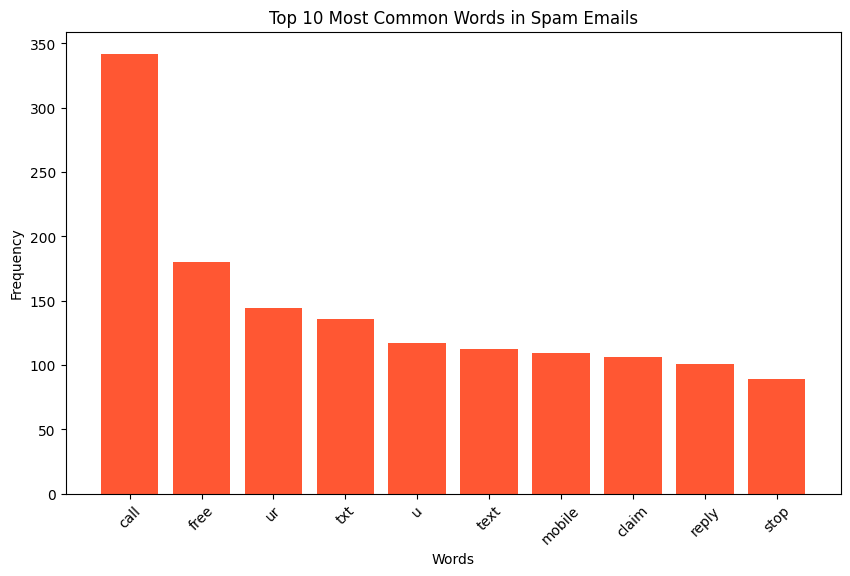

In [10]:
# Data visualization - Top 10 Most Common Words in Spam Emails

stop_words = set(stopwords.words('english'))
spam_words = " ".join(data[data['Category'] == 0]['Message']).split()
ham_words = " ".join(data[data['Category'] == 1]['Message']).split()

spam_word_freq = Counter([word.lower() for word in spam_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*spam_word_freq.most_common(10)), color='#FF5733')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
plt.show()

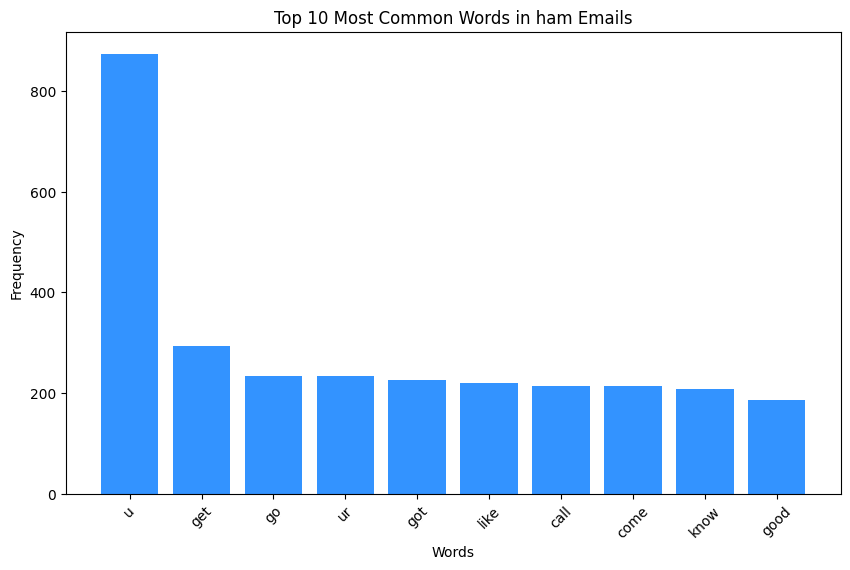

In [11]:
ham_word_freq = Counter([word.lower() for word in ham_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*ham_word_freq.most_common(10)), color='#3393FF')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in ham Emails')
plt.xticks(rotation=45)
plt.show()

# **New features**

In [12]:
data["nb_char"] = data["Message"].apply(len)
data["nb_words"] = data.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)
data["nb_senctences"] = data.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

data.describe().T.style.background_gradient(cmap = "Blues_r")

,count,mean,std,min,25%,50%,75%,max
nb_char,5572.000000,80.118808,59.690841,2.000000,36.000000,61.000000,121.000000,910.000000
nb_words,5572.000000,18.699390,13.741932,1.000000,9.000000,15.000000,27.000000,220.000000
nb_senctences,5572.000000,1.996411,1.520159,1.000000,1.000000,1.500000,2.000000,38.000000


<Axes: >

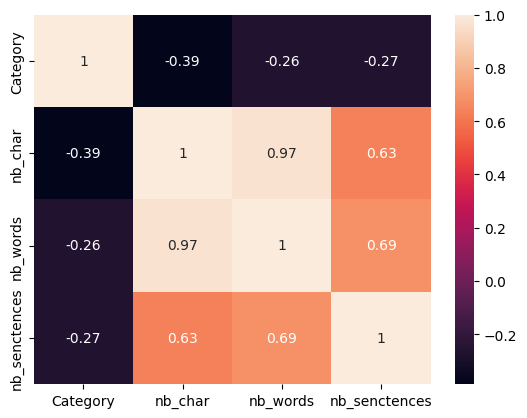

In [13]:
#heatmap
sns.heatmap(data[["Category","nb_char","nb_words","nb_senctences"]].corr(),annot=True)

In [14]:
df = data.copy(deep=True)
df.loc[df["Category"] == 0, "Category"] = "spam"
df.loc[df["Category"] == 1, "Category"] = "ham"

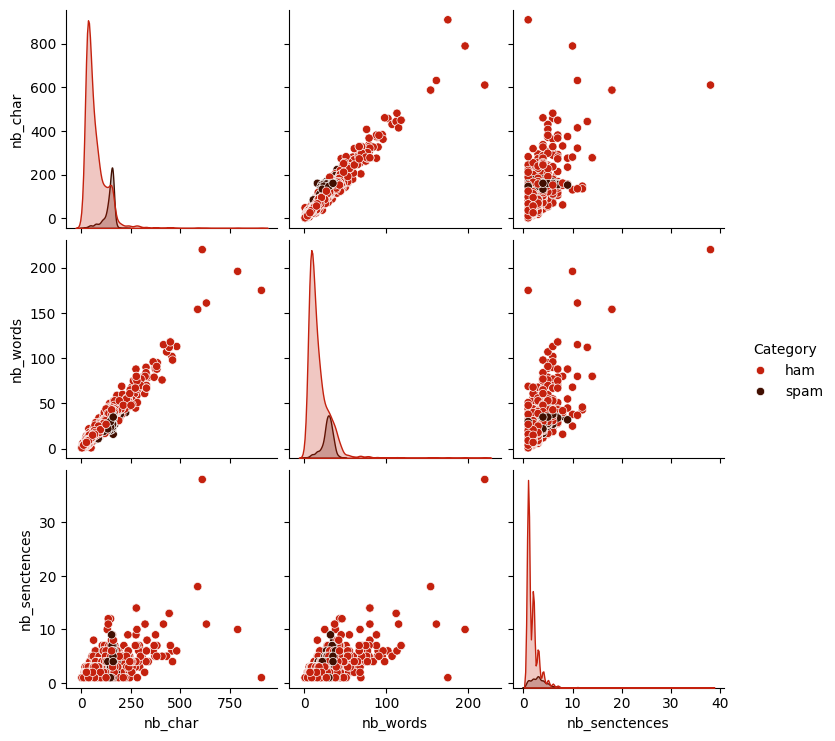

In [15]:
fig = sns.pairplot(data = df, hue = "Category", palette = ["#C4210E", "#410F01"])
plt.show(fig)

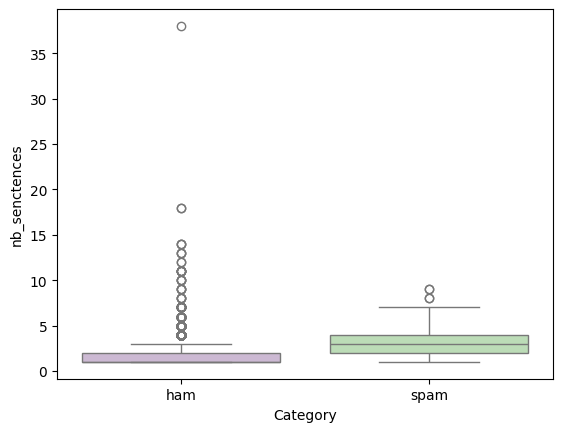

In [16]:
sns.boxplot(x="Category", y='nb_senctences', hue="Category", data=df, palette="PRGn")
plt.show()

In [17]:
#Get every words from dataset and append them to 'corpus' list
corpus = []
for i in data.Message:
    for j in i.split():
        corpus.append(j.strip())
#Count the words
counter = Counter(corpus)
common_words = counter.most_common(3000)
text1 = [common_words[i][0] for i in range(len(common_words))]

<function matplotlib.pyplot.show(close=None, block=None)>

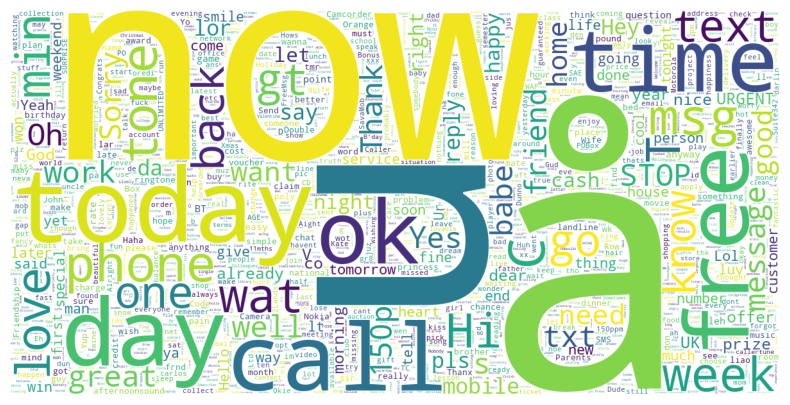

In [18]:
#Visualisation with wordcloud
text = " ".join(text1[i] for i in range(len(text1)))

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words =2000,
               scale = 1, collocations = False, repeat = False, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 5])
plt.imshow(wc)
plt.axis("off")
plt.show

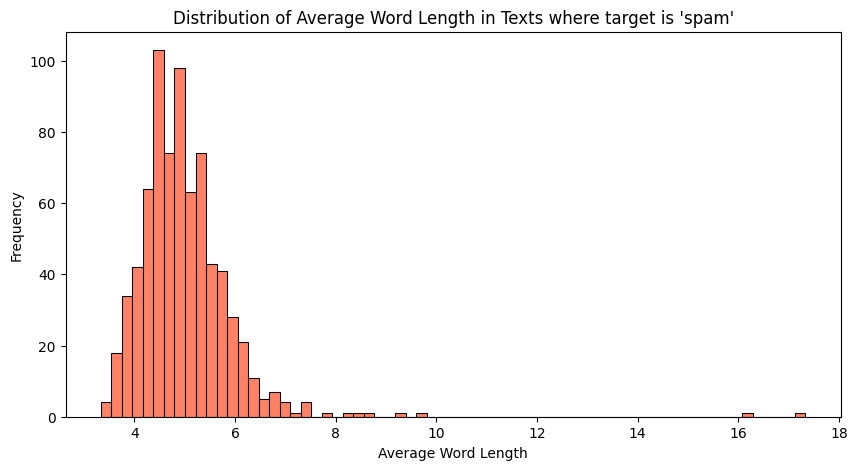

In [19]:
#Distribution of average word length
fig,ax = plt.subplots(figsize = (10, 5))
text_words = data[data["Category"] == 0]["Message"].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(text_words.map(lambda x: np.mean(x) ), color = "#FF5733", ax = ax)
ax.set_xlabel("Average Word Length")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Average Word Length in Texts where target is 'spam'")
plt.show()

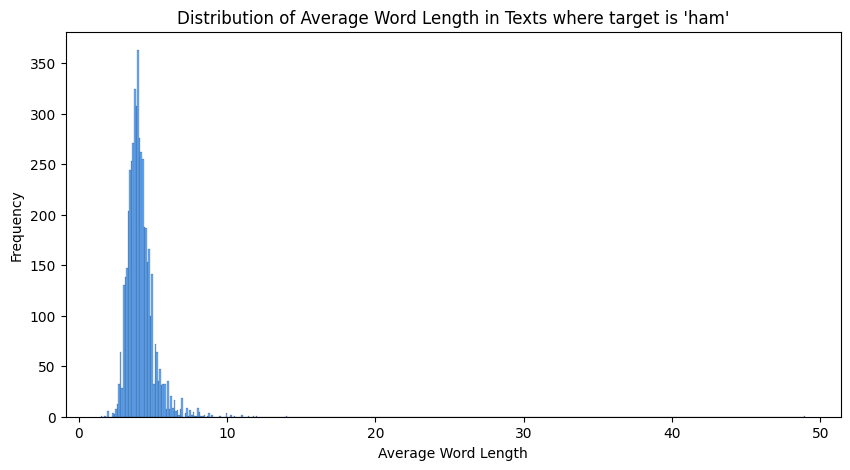

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
text_words_ham = data[data["Category"] == 1]["Message"].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(text_words_ham.map(lambda x: np.mean(x)), color="#3393FF", ax=ax)
ax.set_xlabel("Average Word Length")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Average Word Length in Texts where target is 'ham'")
plt.show()

In [21]:
trace1 = go.Scatter3d(x=df.nb_char,y=df.nb_words,z=df.nb_senctences,mode='markers',marker=dict(size=10,color='rgb(255,0,0)'  ))
df = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0  ))
fig = go.Figure(data=df, layout=layout)
iplot(fig)

# Modeling

In [22]:
X = data["Message"]
Y = data["Category"]

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [24]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(5572,)
(4457,)
(1115,)


In [25]:
print(Y.shape)
print(Y_train.shape)
print(Y_test.shape)

(5572,)
(4457,)
(1115,)


In [26]:
# Create a TF-IDF vectorizer to convert text messages into numerical features
feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [27]:
# Convert the training and testing text messages into numerical features using TF-IDF

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [28]:
# Convert the target values to integers (0 and 1)

Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")


In [29]:
print(X_train.head())
print(X_train_features) 

3075    Mum, hope you are having a great day. Hoping t...
1787                           Yes:)sura in sun tv.:)lol.
1614    Me sef dey laugh you. Meanwhile how's my darli...
4304                Yo come over carlos will be here soon
3266                    Ok then i come n pick u at engin?
Name: Message, dtype: object
  (0, 741)	0.3219352588930141
  (0, 3979)	0.2410582143632299
  (0, 4296)	0.3891385935794867
  (0, 6599)	0.20296878731699391
  (0, 3386)	0.3219352588930141
  (0, 2122)	0.38613577623520473
  (0, 3136)	0.440116181574609
  (0, 3262)	0.25877035357606315
  (0, 3380)	0.21807195185332803
  (0, 4513)	0.2909649098524696
  (1, 4061)	0.380431198316959
  (1, 6872)	0.4306015894277422
  (1, 6417)	0.4769136859540388
  (1, 6442)	0.5652509076654626
  (1, 7443)	0.35056971070320353
  (2, 933)	0.4917598465723273
  (2, 2109)	0.42972812260098503
  (2, 3917)	0.40088501350982736
  (2, 2226)	0.413484525934624
  (2, 5825)	0.4917598465723273
  (3, 6140)	0.4903863168693604
  (3, 1599)	0.59270918541942

In [30]:
# Create a logistic regression model and train it on the training data

model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [31]:
prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test,prediction_on_test_data)
print("Accuracy on test data:",accuracy_on_test_data)

Accuracy on test data: 0.9623318385650225


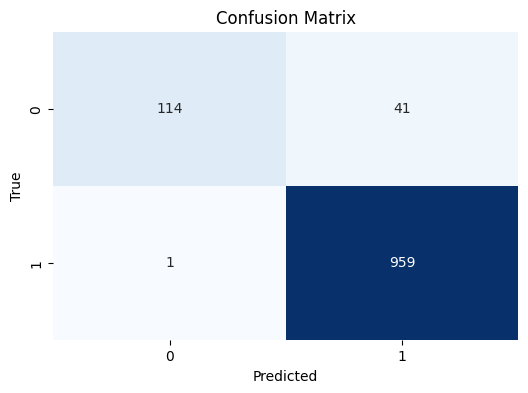

In [32]:
# Data visualization - Confusion Matrix

cm = confusion_matrix(Y_test, prediction_on_test_data)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

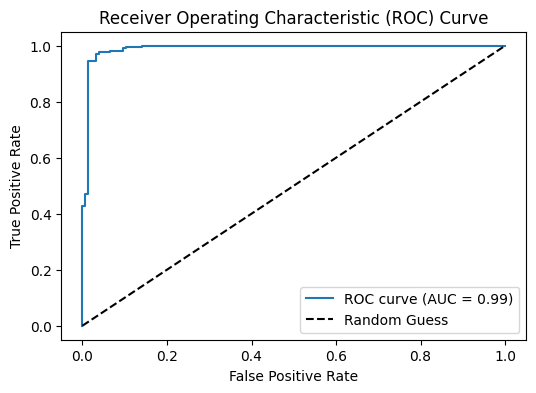

In [33]:
# Data visualization - ROC Curve

probabilities = model.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities)
roc_auc = roc_auc_score(Y_test, probabilities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [34]:
# Make predictions on the training data and calculate the accuracy

prediction_on_training_data = model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)
print("Accuracy",accuracy_on_training_data)

Accuracy 0.9661207089970832


In [35]:
y_pred = model.predict(X_test_features)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

In [36]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9590
Recall: 0.9990
F1 Score: 0.9786


In [37]:
input_your_mail = ["Congratulations! You have won a free vacation to an exotic destination. Click the link to claim your prize now!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")

[0]
Spam Mail


In [38]:
# Test the model with some custom email messages

input_your_mail = ["Meeting reminder: Tomorrow, 10 AM, conference room. See you there!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")

[1]
Ham Mail
